# Deeper dive into pcolormesh()

## Synopsis

- An examination of how pcolormesh expects cell boundaries, and what happens when the cell boundaries are _not_ used.

In [1]:
import matplotlib.pyplot as plt
import xarray
import numpy
import cartopy

## Some test data

We'll make up some simple data to examine how pcolormesh works.

- The mesh will be in longitude-latitude coordinates.
- The mesh will be irregularly spaced along each coordinate direction.
- There will be 6x4 data values in 6x4 cells.
- vlon, vlat will be the 1D coordinates of cell boundaries.
  - Think "V" for vertex.
- clon, clat will be the 1D coordinates of the cell centers, where the notionally data resides.
  - Think "C" for cell center.

In [2]:
# Irregularly space vertex longitudes
vlon = numpy.cumsum([0,60,60,60,45,45,90])-180
# Irregularly space vertex latitudes
vlat = numpy.cumsum([0,45,45,30,60])-90
# Cell centers defined using finite volume interpretation, i.e. middle of cell based on cell bounds
clon = (vlon[:-1]+vlon[1:])/2 # Longitudes of column centers
clat = (vlat[:-1]+vlat[1:])/2 # Latitudes of row centers
# Some arbitrary data to plot
CLON2d, CLAT2d = numpy.meshgrid(clon, clat)
data = (1+numpy.sin(numpy.pi*CLON2d/180)+(0.5-CLAT2d/180)**2)/3
del CLAT2d, CLON2d

## Simple pcolormesh via matplotlib.pyplot

First will use the pcolormesh directly from matplotlib.pyplot.

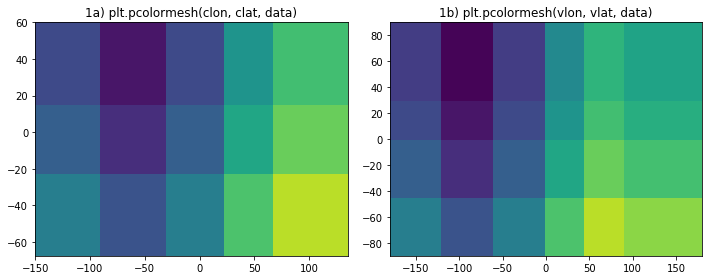

In [3]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.pcolormesh(clon, clat, data, vmin=0, vmax=1);
plt.title('1a) plt.pcolormesh(clon, clat, data)');

plt.subplot(122)
plt.pcolormesh(vlon, vlat, data, vmin=0, vmax=1);
plt.title('1b) plt.pcolormesh(vlon, vlat, data)');

plt.tight_layout()

There should be 6x4 cells of data showing.

- Panel 1a shows only 5x3 values. Moreover, the locations of the cells are wrong.
  - The domain spans from -180<x<180 and -90<y<90 but the figure shows significantly less of the domain.
  - The interface between the 3rd and 4th columns should be at x=0, but is off to the right. Similarly the boundary between the 2nd and 3rd rows should be at y=0 but it to far north. All cell boundaries are wrong.
- Panel 1b correctly shows 6x4 cells with correctly placed boundaries.

## pcolormesh via cartopy

Now let's use cartopy to make the plot.

To use cartopy, you declare the projection you wish to use in the visualization in the axes (i.e. where I use `plt.subplot()` below). When you call pcolormesh for those axes (i.e. with `ax.pcolormesh()`) you normally specify the nature of the coordinates for the data with `transform=`. Since most ESMs provide geographic coordinates then you tend to use `transform=cartopy.crs.PlateCarree()`.

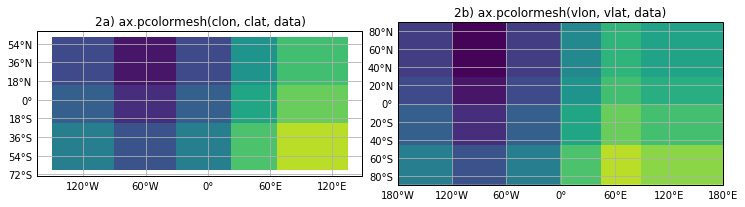

In [4]:
plt.figure(figsize=(10,4))

ax = plt.subplot(121, projection=cartopy.crs.PlateCarree())
ax.pcolormesh(clon, clat, data, transform=cartopy.crs.PlateCarree(), vmin=0, vmax=1);
gl = ax.gridlines(draw_labels=True); gl.xlabels_top,gl.ylabels_right = False,False
gl.xformatter,gl.yformatter = cartopy.mpl.gridliner.LONGITUDE_FORMATTER, cartopy.mpl.gridliner.LATITUDE_FORMATTER
plt.title('2a) ax.pcolormesh(clon, clat, data)');

ax = plt.subplot(122, projection=cartopy.crs.PlateCarree())
ax.pcolormesh(vlon, vlat, data, transform=cartopy.crs.PlateCarree(), vmin=0, vmax=1);
gl = ax.gridlines(draw_labels=True); gl.xlabels_top,gl.ylabels_right = False,False
gl.xformatter,gl.yformatter = cartopy.mpl.gridliner.LONGITUDE_FORMATTER, cartopy.mpl.gridliner.LATITUDE_FORMATTER
plt.title('2b) ax.pcolormesh(vlon, vlat, data)');

plt.tight_layout()

Apart from some handy decoartion of the plot (labels), the behavior for `ax.pcolormesh()` is no different than for `plt.pcolormesh()`:

- Panel 2a shows the wrong number of cells, with the wrong cell bondaries, and does not fill the domain.
- Panel 2b is drawn correctly.

## pcolormesh via xarray

Now to examine how pcolormesh behaves for an xarray `DataSet` (or `DataArray`) we need to define a Dataset. Here, I'm indicating that vlon and vlat could also be coordinates.

In [5]:
ds = xarray.Dataset({'data': (['clat', 'clon'], data)},
                     coords={
                         'clon': (['clon'], clon),
                         'clat': (['clat'], clat),
                         'vlon': (['vlon'], vlon),
                         'vlat': (['vlat'], vlat),
                     }
                   )
ds

<xarray.Dataset>
Dimensions:  (clat: 4, clon: 6, vlat: 5, vlon: 7)
Coordinates:
  * clon     (clon) float64 -150.0 -90.0 -30.0 22.5 67.5 135.0
  * clat     (clat) float64 -67.5 -22.5 15.0 60.0
  * vlon     (vlon) int32 -180 -120 -60 0 45 90 180
  * vlat     (vlat) int32 -90 -45 0 30 90
Data variables:
    data     (clat, clon) float64 0.4219 0.2552 0.4219 ... 0.4702 0.6506 0.5783

Here's see what happens when we use the `.plot()` method and the `.pcolormesh()` method on a cartopy created axes:

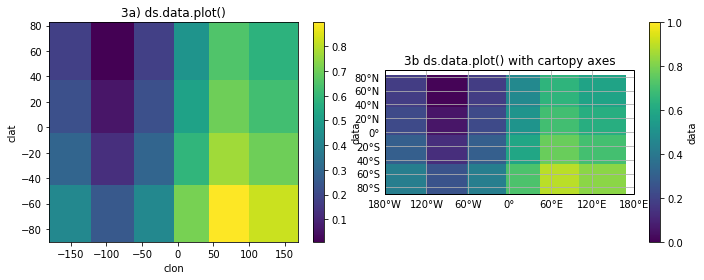

In [6]:
plt.figure(figsize=(10,4))

plt.subplot(121)
ds.data.plot();
plt.title('3a) ds.data.plot()')

ax = plt.subplot(122, projection=cartopy.crs.PlateCarree())
ds.data.plot(transform=cartopy.crs.PlateCarree(), vmin=0, vmax=1);
gl = ax.gridlines(draw_labels=True); gl.xlabels_top,gl.ylabels_right = False,False
gl.xformatter,gl.yformatter = cartopy.mpl.gridliner.LONGITUDE_FORMATTER, cartopy.mpl.gridliner.LATITUDE_FORMATTER
plt.title('3b ds.data.plot() with cartopy axes')

plt.tight_layout()

Good and bad news!

- On the up side, there are 6x4 cells shown in both panels (3a and 3b).
- On the down side, the cell boundaries are not in the correct locations.
- Also, more of the domain is shown than for 1a or 2a but the domain is still not completely filled.

What has happened here is that the good folks behind xarray, knowing that pcolormesh expects cell boundary locations, have calculated the cell boundaries from the cell-center coordinates. It's better than ignoring the problem but unfortunately only gives the correct result for a uniformly spaced mesh.

At this time, I'm unaware of a clean fix for this using xarray so calling `plt.pcolormesh()` with explicit reference to the the cell boundaries, rather than using the help `.plot()` function, seems like the only way to get a correct plot.

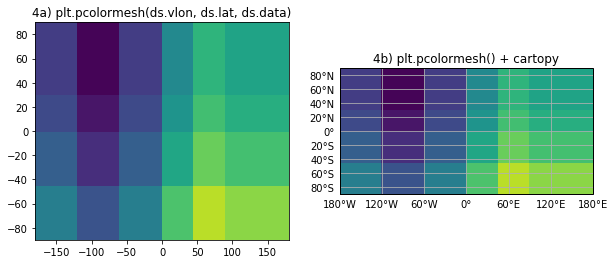

In [7]:
# It would be nice if something like this worked...
# ds.data.plot.pcolormesh(x='vlon',y='vlat',infer_intervals=False)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.pcolormesh(ds.vlon, ds.vlat, ds.data, vmin=0, vmax=1);
plt.title('4a) plt.pcolormesh(ds.vlon, ds.lat, ds.data)');

ax = plt.subplot(122, projection=cartopy.crs.PlateCarree())
plt.pcolormesh(ds.vlon, ds.vlat, ds.data, vmin=0, vmax=1, transform=cartopy.crs.PlateCarree());
gl = ax.gridlines(draw_labels=True); gl.xlabels_top,gl.ylabels_right = False,False
gl.xformatter,gl.yformatter = cartopy.mpl.gridliner.LONGITUDE_FORMATTER, cartopy.mpl.gridliner.LATITUDE_FORMATTER
plt.title('4b) plt.pcolormesh() + cartopy');

## Summary

- We've seen that plotting with pcolormesh only gives the wrong right results when the cell boundary coordinates are provided.
- When data coordinate are used (i.e. not cell boundaries):
  - not all data is plotted;
  - location of data is wrong.
- The xarray helper function, `.plot()`, plots all the data but not necessarily in the right location
  - xarray `.plot()` is still better than raw pcolormesh.